## Extended Born data inversion

In [1]:
import sys
sys.path.append("/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/lib/python/")
import genericIO
import SepVector
import Hypercube
import Acoustic_iso_double
import numpy as np
import time
#Solver library
import pyLCGsolver as LCG
import pyProblem as Prblm
import pyStopperBase as Stopper
from sys_util import logger

In [6]:
#Creating background model
!Pad <velocityMarmousi.H beg1=105 end1=105 beg2=102 end2=102 extend=1 | Pad beg1=5 end1=5 beg2=5 end2=5 > velocityMarmousi.pad.H
!Smooth <velocityMarmousi.pad.H rect1=5 rect2=5 repeat=3 > background.pad.H
#Creating reflectivity
!Add velocityMarmousi.pad.H background.pad.H scale=1,-1 | Pad beg3=50 end3=50 > ext_reflectivity.pad.H
!echo "o3=-0.5" >> ext_reflectivity.pad.H

In [7]:
#Parameters for instantiating nonlinear operator
#First argument is just a dummy one since it mimics the name of the main program (i.e., we mimic sys.argv)
#vel = velocity model header file
#model = wavelet header file
#par = parameter file containing simulation information
args1=["dummy arg","vel=background.pad.H","sources=wlt.H","model=ext_reflectivity.pad.H","par=parPythonTest.p", "nExt=101", "extension=offset"]
modelDouble, dataDouble, velDouble, parObject, sourcesVector, sourcesSignalsVector, receiversVector = Acoustic_iso_double.BornExtOpInitDouble(args1)
#Printing parameter file for reference
!cat parPythonTest.p

3
ext_reflectivity.pad.H
nts=1001
dts=0.004
sub=4
nz=570
nx=1914
zPadMinus=100
zPadPlus=110
xPadMinus=100
xPadPlus=104
dz=0.01
dx=0.01
fMax=16
zSource=10
xSource=850
nShot=50
spacingShots=1
depthReceiver=10
nReceiver=1700
dReceiver=1
oReceiver=1
saveWavefield=0
wavefieldShotNumber=0
blockSize=16
fat=5
nGpu=8


In [8]:
born_ext_op=Acoustic_iso_double.BornExtShotsGpu(modelDouble,dataDouble,velDouble,parObject,sourcesVector,sourcesSignalsVector,receiversVector)
#Running forward operator
t0 = time.time()
born_ext_op.forward(False,modelDouble,dataDouble)
t1 = time.time()
print("Elapsed time = ",t1-t0," seconds")

Elapsed time =  27.795830011367798  seconds


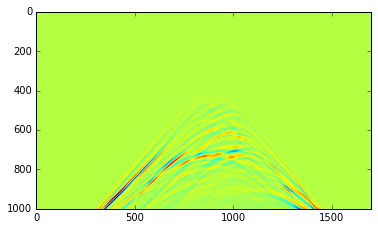

In [9]:
%matplotlib inline  
import matplotlib.pyplot as plt
data = np.reshape(dataDouble.getNdArray()[0,:,:],(1700,1001))
plt.imshow(data.T);

In [10]:
#Create L2-norm linear problem
model_vec = modelDouble.clone()
model_vec.zero()
L2Prob = Prblm.ProblemL2Linear(model_vec,dataDouble,born_ext_op)
#Create stopper
niter = 10
Stop  = Stopper.BasicStopper(niter=niter)
#Create solver
LCGsolver = LCG.LCGsolver(Stop,logger=logger("test.log"))
LCGsolver.setDefaults(iter_buffer=None,iter_sampling=1)
#Running the solver
LCGsolver.run(L2Prob)

LINEAR CONJUGATE GRADIENT SOLVER
Restart folder: /tmp/restart_2019-01-09T17-45-14.214854/

iter = 0 obj = 3.534881256612299e-14 residual norm = 2.658902644725458e-07 gradient norm= 3.518276368483751e-14 feval = 2
iter = 1 obj = 2.2529858939496334e-14 residual norm = 2.122727380537981e-07 gradient norm= 3.518276368483751e-14 feval = 3
iter = 2 obj = 1.8058674572906635e-14 residual norm = 1.9004565388058836e-07 gradient norm= 2.5860481697682555e-14 feval = 5
iter = 3 obj = 1.460028677149984e-14 residual norm = 1.7088174786294985e-07 gradient norm= 2.3705040344936326e-14 feval = 7
iter = 4 obj = 1.1947124481289225e-14 residual norm = 1.545776484590533e-07 gradient norm= 1.863456390333463e-14 feval = 9
iter = 5 obj = 9.665613830158833e-15 residual norm = 1.3903678564020083e-07 gradient norm= 1.694600711111497e-14 feval = 11
iter = 6 obj = 7.927672788243341e-15 residual norm = 1.2591800668815267e-07 gradient norm= 1.5652230352753913e-14 feval = 13
iter = 7 obj = 6.597117111863441e-15 residu